In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import threading
from concurrent.futures import ThreadPoolExecutor
import time
import multiprocessing
from tensorflow import keras
from sudoku_solver import sudoku_solver

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    
    # First Convolutional Block
    tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    # Second Convolutional Block
    tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    # Third Convolutional Block (added for depth)
    tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Flatten and Fully Connected Layers
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, kernel_regularizer= tf.keras.regularizers.l2(l= 0.016), 
                          activity_regularizer= tf.keras.regularizers.l1(0.006),
                          bias_regularizer= tf.keras.regularizers.l1(0.006), 
                          activation= 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(11, activation='softmax')
])

model.load_weights('sudoku2.h5')

In [3]:
puzzles = [os.path.join('puzzles', img) for img in os.listdir('./puzzles/')]

In [4]:
import numpy as np
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

class SudokuDigitPredictor:

    def __init__(self, model, confidence=0.9):
        self.model = model
        self.confidence = confidence
        self.classes = [str(i) for i in range(11)]
        
    # def preprocess_squares_in_parallel(self, warped_sudoku):
    #     with ThreadPoolExecutor(max_workers=4) as executor:  # adjust max_workers as needed
    #         squares = list(executor.map(self.preprocess_for_prediction, [warped_sudoku[y_start:y_start + 28, x_start:x_start + 28] for i in range(9) for j in range(9, x_start=i*28, y_start=j*28)]))
    #     return squares

    def preprocess_for_prediction(self, square):
        """
        Preprocess the cropped square for prediction.
        This depends on how your model expects the input. 
        For example, rescaling, resizing, or reshaping might be necessary.
        """
        # Ensure the square is in grayscale
        if len(square.shape) == 3 and square.shape[2] == 3:
            square = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
            
        # Remove 10 pixels from all sides
        square = square[3:-3, 3:-3]
        # Apply binary threshold
        _, binary = cv2.threshold(square, 127, 255, cv2.THRESH_BINARY)

        # Enhance contrast using histogram equalization
        enhanced_binary = cv2.equalizeHist(binary)
        
        processed_square = cv2.resize(enhanced_binary, (28, 28))  # Resizing
        processed_square = np.expand_dims(processed_square, axis=-1)  # Ensure it has a single channel
        return processed_square

    def predict_digits(self, warped_sudoku):
        """
        Predicts digits for a given warped sudoku grid.
        """
        squares = []
        
        # Crop the sudoku grid into 81 squares
        for i in range(9):
            for j in range(9):
                x_start, y_start = i * 28, j * 28
                square = warped_sudoku[x_start:x_start + 28, y_start:y_start + 28]
                squares.append(self.preprocess_for_prediction(square))

        # Convert list to numpy array for batch prediction
        squares_np = np.stack(squares)

        # Predict
        predictions = self.model.predict_on_batch(squares_np)

        max_confidences = np.amax(predictions, axis=1)
        class_indices = np.argmax(predictions, axis=1)
        
        # Ensure self.classes is a numpy array
        class_array = np.array(self.classes)

        # Determine where predictions exceed the confidence threshold
        above_confidence = max_confidences > self.confidence

        # Use boolean indexing to get relevant classes
        relevant_classes = class_array[class_indices]

        # Where predictions are above the confidence threshold, use predicted class, else '10'
        predicted_classes = np.where(above_confidence, relevant_classes, '10').tolist()
        
        # Convert cell_values to integer-based numpy array, where '10' becomes 0
        cell_values_int = np.array([0 if value == '10' else int(value) for value in predicted_classes])

        # Reshape the numpy array to the desired 9x9 shape
        grid = cell_values_int.reshape(9, 9)
        
        return grid

In [5]:
class SudokuGridHighlighter:

    def __init__(self):
        self.last_contour = None
        self.consistent_detections = 0
        self.detection_threshold = 5
        self.max_area_detected = 0
        self.digit_predictor = SudokuDigitPredictor(model)
        self.grid_prediction = None
        self.sudoku_solution = None
        self.frame_count = 0
        self.predict_every_n_frames = 28
        self.prev_frame = None

    def frame_difference(self, current_frame, prev_frame):
        """
        Compute the difference between current frame and previous frame.
        This will be a simple method, but can be made more sophisticated.
        """
        diff = cv2.absdiff(current_frame, prev_frame)
        return np.average(diff)
    
    def preprocess(self, image):
        """Preprocess the image for contour detection."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (3, 3), 6)
        return cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

    def main_outline(self, contours):
        """Get the largest 4-sided contour in the image."""
        max_area = 0
        biggest_contour = np.array([])
        
        for contour in contours:
            area = cv2.contourArea(contour)
            
            # Adjust the area threshold dynamically
            if area > self.max_area_detected * 0.5 and area > max_area:
                peri = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
                
                if len(approx) == 4:
                    biggest_contour = approx
                    max_area = area
                        
        return biggest_contour, max_area

    def get_cropped_region(self, frame, padding=40):
        """Crops the frame based on the last detected contour and returns the cropped image and its offset."""
        if self.last_contour is None:
            return frame, (0, 0)

        x, y, w, h = cv2.boundingRect(self.last_contour)
        x = max(0, x - padding)
        y = max(0, y - padding)
        w += 2 * padding
        h += 2 * padding

        return frame[y:y+h, x:x+w], (x, y)

    def order_points(self, pts):
        """
        Order the 4 points in this format: top-left, top-right, bottom-right, bottom-left
        """
        rect = np.zeros((4, 2), dtype="float32")

        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]  # top-left will have the smallest sum
        rect[2] = pts[np.argmax(s)]  # bottom-right will have the largest sum

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  # top-right will have the smallest difference
        rect[3] = pts[np.argmax(diff)]  # bottom-left will have the largest difference

        return rect

    def warp_perspective(self, image, contour):
        if contour.shape[0] != 4:
            return None

        ordered_contour = self.order_points(contour.reshape(4, 2))
        src = np.array([
            [0, 0],
            [252 - 1, 0],
            [252 - 1, 252 - 1],
            [0, 252 - 1]
        ], dtype="float32")

        matrix = cv2.getPerspectiveTransform(ordered_contour, src)
        warped = cv2.warpPerspective(image, matrix, (252, 252))
        return warped

    
    def check_sudoku_squares(self, warped_image):
        count_valid_squares = 0

        for i in range(9):
            for j in range(9):
                x_start, y_start = i * 28, j * 28
                square = warped_image[y_start:y_start + 28, x_start:x_start + 28]
                edges = cv2.Canny(square, 50, 150, apertureSize=3)
                lines = cv2.HoughLines(edges, 1, np.pi / 180, 15)
                
                if lines is not None:
                    count_valid_squares += 1

        return count_valid_squares
    
    def _solve_sudoku(self, grid):
        def is_valid_move(x, y, val, grid):
            """Check if placing val at grid[x][y] is valid."""
            
            # Check row and column
            for i in range(9):
                if grid[x][i] == val or grid[i][y] == val:
                    return False
                    
            # Check 3x3 box
            startRow, startCol = 3 * (x // 3), 3 * (y // 3)
            for i in range(3):
                for j in range(3):
                    if grid[i + startRow][j + startCol] == val:
                        return False
                        
            return True

        def _solve_sudoku_helper(grid_copy):
            """Helper function for solve_sudoku."""
            
            for x in range(9):
                for y in range(9):
                    if grid_copy[x][y] == 0:
                        for val in range(1, 10):
                            if is_valid_move(x, y, val, grid_copy):
                                grid_copy[x][y] = val
                                if _solve_sudoku_helper(grid_copy):
                                    return True
                                grid_copy[x][y] = 0
                        return False
            return True

        """Fill the grid using backtracking and return a solved copy."""
            
        # Create a deep copy of the original grid
        grid_copy = np.copy(grid)
        
        if _solve_sudoku_helper(grid_copy):
            return grid_copy
        return None  # Return None if the grid couldn't be solved
    
    def solve_sudoku_timed(self, grid, timeout=0.5):
        """
        Attempt to solve the Sudoku with a time limit.
        If the Sudoku is solved within the time limit, return the solution.
        If not, return None.
        """
        result = {"solution": None}
        
        def worker():
            solution = self._solve_sudoku(grid)
            result["solution"] = solution

        t = threading.Thread(target=worker)
        t.start()
        t.join(timeout=timeout)  # half a second time limit
        
        if t.is_alive():  # if thread is still running after 0.5 seconds
            # Optionally, you might want to log or indicate that solving was terminated due to time constraints
            return None  # or an indication of failure if you prefer
        
        return result["solution"]
       
    def detect_and_highlight_grid(self, image):
        """Detects the Sudoku grid and highlights it."""
        cropped_image, (offset_x, offset_y) = self.get_cropped_region(image)

        preprocessed_image = self.preprocess(cropped_image)
        contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        biggest_contour, max_area = self.main_outline(contours)
        
        warped = self.warp_perspective(cropped_image, biggest_contour)
        if warped is None:
            self.consistent_detections -= 1
            if self.consistent_detections < -3:
                self.last_contour = None
                self.consistent_detections = 0
            return image

        valid_squares = self.check_sudoku_squares(warped)
        
        if valid_squares > 81 * 0.75:
            if biggest_contour.size != 0:
                biggest_contour += np.array([offset_x, offset_y]).reshape(1, 1, 2)

            if max_area > self.max_area_detected:
                self.max_area_detected = max_area

            cv2.drawContours(image, [biggest_contour], 0, (255, 105, 180), 6)
            self.consistent_detections += 1

            if self.consistent_detections > self.detection_threshold:
                self.last_contour = biggest_contour

            # Resizing the warped Sudoku grid to display on the main image
            grid_display_size = (100, 100)  # Adjust size as per your requirements
            small_grid = cv2.resize(warped, grid_display_size)

            # Positioning the warped grid on the bottom right corner of the main image
            image[-grid_display_size[1]:, -grid_display_size[0]:] = small_grid
            
            # Reducing number of predictions
            if self.frame_count % self.predict_every_n_frames == 0:
                if self.prev_frame is not None:
                    diff = self.frame_difference(image, self.prev_frame)
                    
                    print(diff)
                    
                    if diff > 12:
                        self.grid_prediction = self.digit_predictor.predict_digits(warped)
                        # Use the timed solver here
                        solved_grid = self.solve_sudoku_timed(self.grid_prediction)
                        if solved_grid is not None:
                            self.sudoku_solution = solved_grid
                else:
                    self.grid_prediction = self.digit_predictor.predict_digits(warped)
                    # And here
                    solved_grid = self.solve_sudoku_timed(self.grid_prediction)
                    if solved_grid is not None:
                        self.sudoku_solution = solved_grid

        else:
            self.consistent_detections -= 1
            if self.consistent_detections < -3:
                self.last_contour = None
                self.consistent_detections = 0

        print(self.sudoku_solution)
        
        self.frame_count += 1
        self.prev_frame = image.copy()
        
        return image

[[9 3 6 5 4 7 2 8 1]
 [2 1 8 6 9 3 7 4 5]
 [7 4 5 8 2 1 6 3 9]
 [4 7 2 1 3 8 5 9 6]
 [6 8 3 7 5 9 4 1 2]
 [1 5 9 2 6 4 3 7 8]
 [5 9 7 4 1 6 8 2 3]
 [8 2 1 3 7 5 9 6 4]
 [3 6 4 9 8 2 1 5 7]]


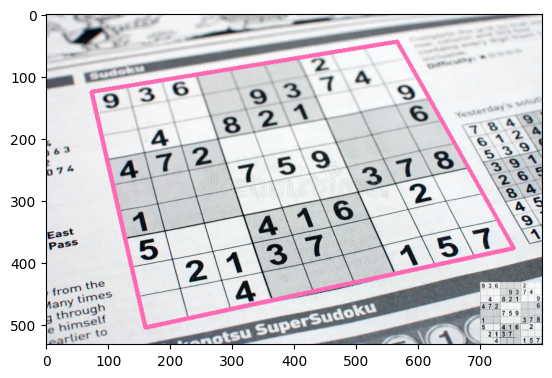

In [6]:
highlighter = SudokuGridHighlighter()

puzzles = [os.path.join('puzzles', img) for img in os.listdir('./puzzles/')]
highlighted_frame = highlighter.detect_and_highlight_grid(cv2.imread(puzzles[0]))
plt.imshow(highlighted_frame)

In [7]:
def webcam_feed():
    highlighter = SudokuGridHighlighter()
    video_capture = cv2.VideoCapture(0)
    video_capture.set(cv2.CAP_PROP_FPS, 30)
    
    # Set resolution
    video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 128)
    video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 128)

    if not video_capture.isOpened():
        print("Error: Could not open webcam.")
        return

    while True:
        ret, frame = video_capture.read()

        if not ret:
            print("Failed to grab frame.")
            break

        highlighted_frame = highlighter.detect_and_highlight_grid(frame)
        cv2.imshow('Webcam Feed - Sudoku Grid Highlighter', highlighted_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video_capture.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    webcam_feed()


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
12.045497495748752
[[8 7 5 9 2 1 3 4 6]
 [3 6 1 7 5 4 8 9 2]
 [2 4 9 8 6 3 7 1 5]
 [5 8 4 6 9 7 1 2 3]
 [7 1 3 2 4 8 6 5 9]
 [9 2 6 1 3 5 4 8 7]
 [6 9 7 4 1 2 5 3 8]
 [1 5 8 3 7 9 2 6 4]
 [4 3 2 5 8 6 9 7 1]]
[[8 7 5 9 2 1 3 4 6]
 [3 6 1 7 5 4 8 9 2]
 [2 4 9 8 6 3 7 1 5]
 [5 8 4 6 9 7 1 2 3]
 [7 1 3

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

class SudokuSolver:
    def __init__(self, model, confidence=0.9):
        self.model = model
        self.confidence = confidence
        self.classes = [str(i) for i in range(11)]
        self.solve_cooldown = 0
        self.solved_grid = None
        self.grid = None
        self.grid_detected_last_frame = False  # Track if the grid was detected in the last frame
    
    @staticmethod
    def timer_decorator(func):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"'{func.__name__}' took {elapsed_time:.6f} seconds to run.")
            return result
        return wrapper

    # @timer_decorator
    def preprocess(self, image):
        """Preprocess the image for contour detection."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (3, 3), 6)
        return cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

    # @timer_decorator
    def main_outline(self, contours):
        """Get the largest 4-sided contour in the image."""
        max_area = 0
        biggest_contour = np.array([])
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 50:
                peri = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
                
                if len(approx) == 4 and area > max_area:
                    biggest_contour = approx
                    max_area = area
                    
        return biggest_contour, max_area

    # @timer_decorator
    def reframe(self, points):
        """Re-order points to top-left, top-right, bottom-left, bottom-right."""
        points = points.reshape((4, 2))
        sorted_points = np.zeros((4, 1, 2), dtype=np.int32)
        
        add = points.sum(1)
        diff = np.diff(points, axis=1)
        
        sorted_points[0], sorted_points[3] = points[np.argmin(add)], points[np.argmax(add)]
        sorted_points[1], sorted_points[2] = points[np.argmin(diff)], points[np.argmax(diff)]
        
        return sorted_points

    # @timer_decorator
    def splitcells(self, img):
        """Split image into 81 cells."""
        return [box for row in np.vsplit(img, 9) for box in np.hsplit(row, 9)]
    
    # @timer_decorator
    def CropCell(self, cells):
        """Crop each cell to remove 10 pixels from each side and convert to binary."""
        binary_cells = []
        for cell in cells:
            cropped = cell[5:-5, 5:-5]
            
            # Convert to grayscale if it's not already
            if len(cropped.shape) == 3 and cropped.shape[2] == 3:
                cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
            
            # Apply binary threshold
            _, binary = cv2.threshold(cropped, 127, 255, cv2.THRESH_BINARY)
            enhanced_binary = self.enhance_contrast(binary)
            binary_cells.append(Image.fromarray(enhanced_binary))
        
        return binary_cells

    # @timer_decorator
    def predict_sudoku_cells(self, cells):
        batch_data = []
        for cell in cells:
            im = tf.keras.preprocessing.image.img_to_array(cell)
            im = cv2.resize(im, (28, 28))
            im = np.expand_dims(im, axis=-1)
            batch_data.append(im)
        batch_data = np.stack(batch_data, axis=0)

        # Predict
        predictions = self.model.predict_on_batch(batch_data)
        
        max_confidences = np.amax(predictions, axis=1)
        class_indices = np.argmax(predictions, axis=1)
        
        # Ensure self.classes is a numpy array
        class_array = np.array(self.classes)

        # Determine where predictions exceed the confidence threshold
        above_confidence = max_confidences > self.confidence

        # Use boolean indexing to get relevant classes
        relevant_classes = class_array[class_indices]

        # Where predictions are above the confidence threshold, use predicted class, else '10'
        predicted_classes = np.where(above_confidence, relevant_classes, '10').tolist()

        return predicted_classes

    # @timer_decorator
    def overlay_solution_on_image(self, image, grid, original_grid):
        """
        Overlay the solved numbers on the original Sudoku image.

        Parameters:
        - image: The original Sudoku image.
        - grid: The solved Sudoku grid.
        - original_grid: The transcribed Sudoku grid from the image.
        """
        
        # Convert grayscale to BGR if image has only one channel
        if len(image.shape) == 2 or image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # Dimensions of the image
        height, width = image.shape[0:2]

        # Dimensions of each cell
        cell_width = width // 9
        cell_height = height // 9

        # Set appropriate font scale and thickness considering the size of the cells
        font_scale = min(cell_width, cell_height) / 40  # Adjust the denominator as needed
        thickness = int(font_scale) * 2

        for x in range(9):
            for y in range(9):
                if original_grid[x][y] == 0:  # If the cell was originally empty
                    cell_value = str(grid[x][y])

                    # Calculate text size
                    (text_width, text_height), _ = cv2.getTextSize(cell_value, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

                    # Determine the position to put the text (approximately in the center of the cell)
                    pos = (y * cell_width + (cell_width - text_width) // 2, 
                        x * cell_height + (cell_height + text_height) // 2)

                    # Overlay the text on the copied image
                    cv2.putText(image, cell_value, pos, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 105, 180), thickness)

        return image
    
    # @timer_decorator
    def solve_sudoku(self, grid):
        def is_valid_move(x, y, val, grid):
            """Check if placing val at grid[x][y] is valid."""
            
            # Check row and column
            for i in range(9):
                if grid[x][i] == val or grid[i][y] == val:
                    return False
                    
            # Check 3x3 box
            startRow, startCol = 3 * (x // 3), 3 * (y // 3)
            for i in range(3):
                for j in range(3):
                    if grid[i + startRow][j + startCol] == val:
                        return False
                        
            return True

        def _solve_sudoku_helper(grid_copy):
            """Helper function for solve_sudoku."""
            
            for x in range(9):
                for y in range(9):
                    if grid_copy[x][y] == 0:
                        for val in range(1, 10):
                            if is_valid_move(x, y, val, grid_copy):
                                grid_copy[x][y] = val
                                if _solve_sudoku_helper(grid_copy):
                                    return True
                                grid_copy[x][y] = 0
                        return False
            return True

        """Fill the grid using backtracking and return a solved copy."""
            
        # Create a deep copy of the original grid
        grid_copy = np.copy(grid)
        
        if _solve_sudoku_helper(grid_copy):
            return grid_copy
        return None  # Return None if the grid couldn't be solved
    
    # @timer_decorator
    def solve_sudoku_with_timeout(self, grid, timeout=0.005):
        result = [None] # Use a list to store the result since lists are mutable
        solved_event = threading.Event() # Event flag to signal when the solving is done

        def worker():
            result[0] = self.solve_sudoku(grid)
            solved_event.set()  # Signal that the solving is done

        thread = threading.Thread(target=worker)
        thread.start()
        solved_event.wait(timeout=timeout)

        if thread.is_alive():
            # Stop the thread if it's still running (not recommended in real applications)
            # Ideally, you would let the thread finish its work in the background
            # If you really need to stop threads, consider using multiprocessing instead
            print("Solver took too long!")
            return None

        return result[0]
    
    # @timer_decorator
    def inverse_transform_and_overlay(self, overlayed_image, original_image, matrix):
        """Inverse transform the overlayed_image and overlay on original image."""
        inversed = cv2.warpPerspective(overlayed_image, np.linalg.inv(matrix), (original_image.shape[1], original_image.shape[0]))
        mask = cv2.warpPerspective(np.ones_like(overlayed_image) * 255, np.linalg.inv(matrix), (original_image.shape[1], original_image.shape[0]))
        
        # Apply mask to original image to black out the Sudoku area
        masked_original = cv2.bitwise_and(original_image, 255 - mask)

        # Combine the masked original image with the inversed transformed image
        combined = cv2.bitwise_or(masked_original, inversed)

        return combined

    @staticmethod
    def get_side_lengths(points):
        """Return lengths of sides of the quadrilateral defined by points."""
        p = points.reshape(4, 2)
        lengths = [
            np.linalg.norm(p[0] - p[1]),
            np.linalg.norm(p[1] - p[2]),
            np.linalg.norm(p[2] - p[3]),
            np.linalg.norm(p[3] - p[0])
        ]
        return lengths
    
    # @timer_decorator
    def enhance_contrast(self, cell):
        """Enhance the contrast of the image using histogram equalization."""
        equalized = cv2.equalizeHist(cell)
        return equalized

    # @timer_decorator
    def warp_grid_to_standard(self, img):
            """Warp the grid such that it aligns perfectly with the standard grid lines."""
            target_points = np.array([
                [0, 0],
                [449, 0],
                [449, 449],
                [0, 449]
            ], dtype=np.float32)

            h, w = img.shape[:2]
            src_points = np.array([
                [0, 0],
                [w-1, 0],
                [w-1, h-1],
                [0, h-1]
            ], dtype=np.float32)
            
            matrix = cv2.getPerspectiveTransform(src_points, target_points)
            aligned_img = cv2.warpPerspective(img, matrix, (450, 450))
            return aligned_img

    # @timer_decorator
    def _find_grid_lines(self, image):
        threshold = self.preprocess(image)
        contour, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        biggest, _ = self.main_outline(contour)
        
        if biggest.size != 0:
            biggest = self.reframe(biggest)
            
            # If a grid was detected in the last frame, compare side lengths
            if self.grid_detected_last_frame:
                previous_lengths = self.get_side_lengths(self.last_detected_grid)
                current_lengths = self.get_side_lengths(biggest)
                diff = np.abs(np.array(previous_lengths) - np.array(current_lengths))
                if np.any(diff > 300):
                    print(diff)
                    print("Grid is too different from the last frame, skipping this frame.")
                    return (None, None)
                    
            # Store this grid for comparison in the next frame
            self.last_detected_grid = biggest
            
            pts1 = np.float32(biggest)
            pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
            matrix = cv2.getPerspectiveTransform(pts1,pts2)
            if np.linalg.det(matrix) == 0:
                # Matrix is singular and can't be inverted
                print("Singular matrix detected, skipping this frame.")
                return (None, None)
        
            imagewrap = cv2.warpPerspective(image, matrix, (450,450))
            imagewrap = cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)

            # Warp the grid to make it standard
            imagewrap = self.warp_grid_to_standard(imagewrap)
            
            if imagewrap is None:
                self.grid_detected_last_frame = False
            else:
                self.grid_detected_last_frame = True
                
            return (imagewrap, matrix)
        else:
            return (None, None)
    
    def solve(self, image, frame_count):
        # Only run the solver logic every 5 frames
        if frame_count % 5 == 0:
            if self.solve_cooldown > 0:
                self.solve_cooldown -= 1
                print(f'cooldown: {self.solve_cooldown}')

            # look for grid lines
            imagewrap, matrix = self._find_grid_lines(image)
            
            # Check if grid was detected in this frame but not in the last frame
            grid_just_detected = imagewrap is not None and not self.grid_detected_last_frame
            
            if imagewrap is None:
                return image

            if (frame_count % 10 == 0 and self.solve_cooldown == 0) or grid_just_detected:
                start_time = time.time()
                # Reset cooldown
                self.solve_cooldown = 15
                self.solved_sudoku = None
                self.grid = None
                self.frame_count = 0

                cells = self.splitcells(imagewrap)
                self.cells_cropped = self.CropCell(cells)

                # Using batch prediction
                cell_values = self.predict_sudoku_cells(self.cells_cropped)
                
                # Convert cell_values to integer-based numpy array, where '10' becomes 0
                cell_values_int = np.array([0 if value == '10' else int(value) for value in cell_values])

                # Reshape the numpy array to the desired 9x9 shape
                self.grid = cell_values_int.reshape(9, 9)

                # Instead of solving directly, use ThreadPoolExecutor
                with ThreadPoolExecutor() as executor:
                    future = executor.submit(self.solve_sudoku_with_timeout, self.grid)
                    self.solved_grid = future.result()
                    
                if self.solved_grid is not None:
                    print('solved!')
                    print(self.solved_grid)
                    end_time = time.time()
                    print(f"Time taken for solve: {end_time - start_time} seconds")

    
    def overlay(self, image):
        start_time = time.time()
        if self.solved_grid is None or self.grid is None:
            return image

        # look for grid lines
        imagewrap, matrix = self._find_grid_lines(image)
        if imagewrap is None:
            return image
        
        overlayed_image = self.overlay_solution_on_image(imagewrap, self.solved_grid, self.grid)
        combined_image = self.inverse_transform_and_overlay(overlayed_image, image, matrix)
        end_time = time.time()
        print(f"Time taken for overlay function: {end_time - start_time} seconds")
        return combined_image

In [ ]:
solver = SudokuSolver(model, confidence=0.95)

In [ ]:
puzzles = [os.path.join('puzzles', img) for img in os.listdir('./puzzles/')]
solved_sudoku = solver.solve(cv2.imread(puzzles[0]), frame_count=10)
overlayed_frame = solver.overlay(cv2.imread(puzzles[0]))
plt.imshow(overlayed_frame)

In [ ]:
def webcam_sudoku_solver(model):
    # Initialize the webcam
    cap = cv2.VideoCapture(0)  # Use 0 for default webcam
    cap.set(cv2.CAP_PROP_FPS, 10)
    
    # Set resolution
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 64)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 64)

    if not cap.isOpened():
        print("Error: Couldn't open the webcam.")
        return
    
    # Create an instance of the SudokuSolver
    sudoku_solver = SudokuSolver(model)
    frame_count = 0

    while True:
        frame_count += 1

        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        sudoku_solver.solve(frame, frame_count)
        overlayed_frame = sudoku_solver.overlay(frame)
        
        cv2.imshow('Webcam Sudoku Solver', overlayed_frame)
        
        # Press 'q' to exit the loop and close the webcam feed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and destroy all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

# Placeholder for your trained model
webcam_sudoku_solver(model)

In [ ]:
def webcam_feed():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FPS, 15)

    frame_skip = 10  # process every 10th frame
    frame_count = 0

    # Instantiate the solver once here
    solver = SudokuSolver(model)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        frame_count += 1
        if frame_count % frame_skip == 0:
            # Pass the frame to the existing solver instance
            solved_frame = solver.solve_frame(frame)

            if solved_frame is not None:
                cv2.imshow('Sudoku Solver', solved_frame)
            else:
                cv2.imshow('Sudoku Solver', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

webcam_feed()


In [ ]:
image = cv2.imread(puzzles[0])
height, width = 480, 480  # example dimensions
resized_image = cv2.resize(image, (width, height))

In [ ]:
plt.imshow(resized_image)

In [ ]:
gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [ ]:
plt.imshow(blurred)

In [ ]:
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
plt.imshow(thresh)

In [ ]:
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
for contour in contours:
    if len(cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)) == 4:
        grid_contour = contour
        break

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

rect = order_points(grid_contour.reshape(4, 2))
(topLeft, topRight, bottomRight, bottomLeft) = rect
maxWidth = max(int(cv2.norm(bottomRight, bottomLeft)), int(cv2.norm(topRight, topLeft)))
maxHeight = max(int(cv2.norm(topRight, bottomRight)), int(cv2.norm(topLeft, bottomLeft)))
dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
transformMatrix = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(resized_image, transformMatrix, (maxWidth, maxHeight))


plt.imshow(warp)